Names: Aman Tewari, Ebaad Imran, Akin Bilen, Jake Medina 

We have two main goals for this project, we will first attempt to predict where songs rank on the apple charts based on selected features. We want to approach this as a classification problem, as we care less about the exact ranking of a song, and more about how relatively popular it is going to be on the charts. Thus, we will split Apple rankings into 5 classes, apple_chart_category_276+,	apple_chart_category_1-50, apple_chart_category_51-100, apple_chart_category_101-200, apple_chart_category_201-275, and attempt to predict which class a given song falls under. 

We specifically chose the apple chart because it appears to be a chart that doesn't only rank based on number of streams, the first cell of part 2 demostrates that there is only a rougly .38 correlation between average_streams_per_year and ranking, implying there are other factors that apple chooses to use to rank songs, and we want to explore what they are, or at least what we need to predict them. 

The second goal of the project is much more ambitious, we wish to predict roughly the stream count of a song based on only features that would be given pre-release, i.e. we can't use features like in_spotify_playlists which describes how many spotify playlists contain the song. This would be very useful because it would create a model that producer could use to engineer a song that is "supposed" to top charts and honestly probably what happens in the industry today. Note: we chose streams rather than avg_streams_per_year because we have a date associated with our data, so it's interesting to use that, and if a song is in this dataset and older than a couple years it was probably a good example of a song that has stayed relevant over time which makes our predictions more accurate. Of course, we would need much more training data to do this with a hypothetical song, but it's a good proof of concept.

For fun we added a third goal, attempting to see if we could guess the "stream_ranking" of a song using all the features except streams, but of course this is a much easier task, and we can use a simple regression.


Part 1: Data Collection and Cleanup

In [62]:
# ML Project

# headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [63]:
raw_data = pd.read_csv("spotify-2023.csv", skipinitialspace = True)
# raw_data.drop(raw_data['in_shazam_charts'], axis=1, inplace=True)
print(raw_data.head())

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703               

In [64]:
print(raw_data.info())

# let's check for missing values
missing_values = raw_data.isna().sum()
print(missing_values)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    int64 
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [65]:
# it seems that there are some blank values in the shazam_charts column.
# let's check how many values have a value 0

zero_counts = (raw_data == 0).sum()
zero_counts 

track_name                0
artist(s)_name            0
artist_count              0
released_year             0
released_month            0
released_day              0
in_spotify_playlists      0
in_spotify_charts       405
streams                   0
in_apple_playlists       23
in_apple_charts         100
in_deezer_playlists       0
in_deezer_charts        558
in_shazam_charts          0
bpm                       0
key                       0
mode                      0
danceability_%            0
valence_%                 0
energy_%                  0
acousticness_%           60
instrumentalness_%      866
liveness_%                0
speechiness_%             0
dtype: int64

In [66]:
max_values_spot = raw_data['in_spotify_charts'].max()
max_values_deez = raw_data['in_deezer_charts'].max()
max_values_app = raw_data['in_apple_charts'].max()
print(max_values_spot, max_values_deez, max_values_app)

147 58 275


In [67]:
# print out rows that have 0 in Apple, Spotify, AND Deezer charts. That is bad.

# a mirror of all of the records
# the value is false if it doesn't meet the condition
# the value is true otherwise
all_zero_chart_rankings = ((raw_data['in_spotify_charts'] == 0) & (raw_data['in_deezer_charts'] == 0) & (raw_data['in_apple_charts'] == 0))

# print(all_zero_chart_rankings)
print((all_zero_chart_rankings == False).sum())

# only print rows of raw_data where the matching row from all_zero_chart_rankings is True
filtered_df = raw_data[all_zero_chart_rankings]
# print(filtered_df)  # 0 rows
print(filtered_df['in_spotify_charts'].sum())  # 0'])
print(filtered_df['in_deezer_charts'].sum())  # 0'])
print(filtered_df['in_apple_charts'].sum())  # 0']) 


# There are 65 records in total that have 0 in all three charts.

# We can try to weigh charts with the total missing values for each chart.
# We can try to 

888
0
0
0


In [68]:

some_zero_chart_rankings = ((raw_data['in_spotify_charts'] == 0) | (raw_data['in_deezer_charts'] == 0) | (raw_data['in_apple_charts'] == 0))
print((all_zero_chart_rankings == 0).sum())
filtered_df = raw_data[some_zero_chart_rankings]
print(filtered_df)  # 0 rows
print((filtered_df['in_spotify_charts'] == 0).sum())  # 0'])
print((filtered_df['in_deezer_charts']== 0).sum())  # 0'])
print((filtered_df['in_apple_charts'] == 0).sum())  # 0']) 

# There are 627(includes 65 records that have no ranking) records in total that are missing at least one ranking from the Spotify, Deezer, or Apple charts.

# TODO: We did not include Shazam charts in this analysis. We should include Shazam charts in this analysis.
# There are no MISSING values in Spotify, Deezer, Apple charts, BUT there are 50 missing values in Shazam charts so we have to remember to add those in

888
                                  track_name                artist(s)_name  \
29   Dance The Night (From Barbie The Album)                      Dua Lipa   
47                               Die For You                    The Weeknd   
53              (It Goes Like) Nanana - Edit                     Peggy Gou   
62   Left and Right (Feat. Jung Kook of BTS)  Charlie Puth, BTS, Jung Kook   
66                                     Karma                  Taylor Swift   
..                                       ...                           ...   
947                            The Great War                  Taylor Swift   
948                             My Mind & Me                  Selena Gomez   
949                Bigger Than The Whole Sky                  Taylor Swift   
950                     A Veces (feat. Feid)            Feid, Paulo Londra   
951                            En La De Ella            Feid, Sech, Jhayco   

     artist_count  released_year  released_month  released_

In [69]:
"""
Add season column as a new feature
"""
print(len(raw_data))
seasons = []
# print(len(raw_data.iterrows()))
for index,row in raw_data.iterrows():
    if row['released_month'] in [12,1,2]:
        seasons.append('winter')
    elif row['released_month'] in [3,4,5]:
        seasons.append('spring')
    elif row['released_month'] in [6,7,8]:
        seasons.append('summer')
    elif row['released_month'] in [9,10,11]:
        seasons.append('fall')
    else:
        seasons.append('unknown')

raw_data['season'] = seasons
print(raw_data['season'])
print(raw_data['season'].value_counts())

953
0      summer
1      spring
2      summer
3      summer
4      spring
        ...  
948      fall
949      fall
950      fall
951      fall
952      fall
Name: season, Length: 953, dtype: object
season
spring    280
winter    270
fall      209
summer    194
Name: count, dtype: int64


In [70]:
"""
Add ranking column
"""
raw_data['stream_ranking'] = raw_data['streams'].rank(ascending=False).astype(int)
print((raw_data[['track_name', 'artist(s)_name', 'streams', 'stream_ranking']]).sort_values(by='stream_ranking').head(20))

                                        track_name  \
55                                 Blinding Lights   
179                                   Shape of You   
86                               Someone You Loved   
620                                   Dance Monkey   
41   Sunflower - Spider-Man: Into the Spider-Verse   
162                                      One Dance   
84                       STAY (with Justin Bieber)   
140                                       Believer   
725                                         Closer   
48                                         Starboy   
138                                        Perfect   
71                                      Heat Waves   
14                                       As It Was   
693                                          Se��o   
324                           Say You Won't Let Go   
128                           lovely - Bonus Track   
127                               Watermelon Sugar   
407                         

In [71]:
"""Add average streams per year column, this should be helpful on comparing songs that were released in different years, but not overall ranking"""
""""Now newers songs that haven't had as much time to accumulate strings get more presence in the ranking."""""
raw_data['average_streams_per_year'] = raw_data['streams'] / (2024 - raw_data['released_year'])
pd.options.display.float_format = '{:.2f}'.format
print((raw_data[['track_name', 'released_year', 'streams', 'average_streams_per_year']]).sort_values(by='average_streams_per_year', ascending=False).head(20))

                                track_name  released_year     streams  \
12                                 Flowers           2023  1316855716   
14                               As It Was           2022  2513188493   
84               STAY (with Justin Bieber)           2021  2665343922   
55                         Blinding Lights           2019  3703895074   
6                          Ella Baila Sola           2023   725980112   
133  Shakira: Bzrp Music Sessions, Vol. 53           2023   721975598   
87                         Me Porto Bonito           2022  1440757818   
74   Quevedo: Bzrp Music Sessions, Vol. 52           2022  1356565093   
71                              Heat Waves           2020  2557975762   
192                       Titi Me Pregunt�           2022  1264310836   
513                               good 4 u           2021  1887039593   
535                        drivers license           2021  1858144199   
34                                     TQG         

In [72]:
""""Bin bpm into 3 categories: slow, medium, fast(Thresholds were determined by general bpm differentiation across genres)"""
bpm_col = raw_data['bpm']
bpm_bins = [0, 105, 130, 300]
bpm_labels = [1, 2, 3]
raw_data['bpm_category'] = pd.cut(x =bpm_col, bins=bpm_bins, labels=bpm_labels)


# DELETE raw_data['bpm'] ?? 
# raw_data.drop(['bpm'], axis=1, inplace=True)
print(raw_data['bpm_category'].value_counts())

bpm_category
3    338
1    308
2    307
Name: count, dtype: int64


In [73]:
'''Spotify charts: binary label, 1 for in charts, 0 for not in charts
This can be used as an alternative class label.
We are using this label because we are trying to predict whether a song will be charted on Spotify
'''

# all zero values indicate that a song was not charted

# create a new column called charted_on_spotify

charted_on_spotify = raw_data['in_spotify_charts'] != 0
raw_data['charted_on_spotify'] = charted_on_spotify
print(raw_data['charted_on_spotify'].value_counts())

charted_on_spotify
True     548
False    405
Name: count, dtype: int64


In [74]:
'''Apple charts: binned, 1-100, 101-200, 201-275, 276+'''
'''This could also be used as a class label, or a feature'''

# we are assuming that every row with an "in_apple_charts" value of 0 is a song that didn't make the top 275 charts
# initially the bins were 1-100, 101-200, 201-275, 276+ and the result is:
'''1-100      677
   101-200    163
   276+       100
   201-275     13'''

# Because the 1-100 bin has the most values, we are going to change the bins to 1-50, 51-100, 101-200, 201-275, 276+
# So that the bins are less skewed
apple_chart_bins = [-1, 0, 51, 101, 201, 276]
apple_chart_labels = [ 5, 1, 2, 3, 4]
raw_data['class_label_apple_chart_category'] = pd.cut(x = raw_data['in_apple_charts'], bins=apple_chart_bins, labels=apple_chart_labels)

print(raw_data['class_label_apple_chart_category'].value_counts())

# one-hot encode the apple_chart_category column

#raw_data = pd.get_dummies(raw_data, columns=['apple_chart_category'])
print(raw_data.head())

class_label_apple_chart_category
1    439
2    243
3    158
5    100
4     13
Name: count, dtype: int64
                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_char

In [75]:
'''We have decided to fill in the missing values of the 'key' column based on
the probability distribution of the 'keys' that exist in the data set.'''

keys = raw_data['key'].dropna().unique()
counts = raw_data['key'].value_counts()
sums = raw_data['key'].value_counts().sum()
counts = counts / sums
for i in range(1,len(keys)):
    counts.iloc[i] = counts.iloc[i] + counts.iloc[i-1]

print(counts)

import random
# random number between 0 and 1

# for each record with column value ['key'] that is n/a, choose a random number bewteen 0 and 1
# set the key value to the corresponding key value in counts

print('before', raw_data['key'].value_counts())

def get_key(num):
    for i in range(len(counts)):
        if num < counts.iloc[i]:
            return keys[i]
    return keys[len(keys)-1]

new_data_with_key_filled_in = raw_data['key'].apply(lambda x: get_key(random.uniform(0,1)) if pd.isna(x) else x)
raw_data['key'] = new_data_with_key_filled_in

# print out number of missing values in key column
print('after', new_data_with_key_filled_in.value_counts())



key
C#   0.14
G    0.25
G#   0.36
F    0.46
B    0.56
D    0.65
A    0.74
F#   0.82
E    0.90
A#   0.96
D#   1.00
Name: count, dtype: float64
before key
C#    120
G      96
G#     91
F      89
B      81
D      81
A      75
F#     73
E      62
A#     57
D#     33
Name: count, dtype: int64
after key
C#    133
G     104
F     103
G#     99
B      91
D      91
A      90
F#     80
E      63
A#     61
D#     38
Name: count, dtype: int64


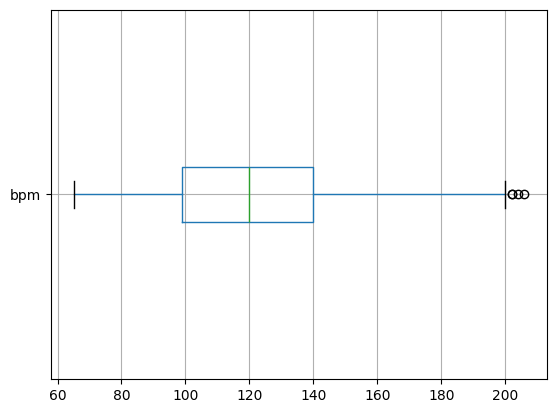

count   953.00
mean    122.40
std      27.98
min      65.00
25%      99.00
50%     120.00
75%     140.00
max     206.00
Name: bpm, dtype: float64

In [76]:
'''Explore BPM data'''


raw_data.boxplot(column='bpm', vert=False)
plt.show()
raw_data['bpm'].describe()

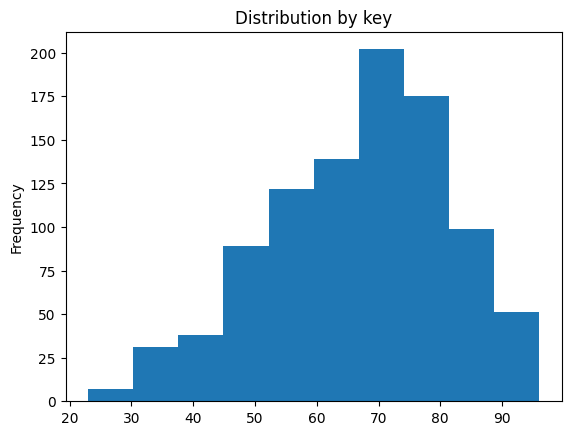

count   953.00
mean     66.97
std      14.63
min      23.00
25%      57.00
50%      69.00
75%      78.00
max      96.00
Name: danceability_%, dtype: float64

In [77]:
raw_data['danceability_%'].plot(kind='hist', title='Distribution by key')
plt.show()
raw_data['danceability_%'].describe()

Part 2: Feature Engineering

In [78]:
correlation = raw_data['average_streams_per_year'].corr(raw_data['in_apple_charts'])
correlation2 = raw_data['in_apple_playlists'].corr(raw_data['in_apple_charts'])
print("Correlation between Streams and Apple Charts:", correlation)
print("Correlation between Apple Playlists and Apple Charts:", correlation2)
#Justification of why we chose apple specifically, isn't soley based off streams/how many playlists have it

Correlation between Streams and Apple Charts: 0.3829483122725129
Correlation between Apple Playlists and Apple Charts: 0.41452330571208174


In [79]:
# Drop data that doesn't matter to us or that we have already processed into a seperate feature or that doesn't matter to us (avg_streams_per_year) 
# because we have total streams and years since release
useable_data = raw_data.copy()
useable_data.drop(['in_shazam_charts','released_day', 'released_month', 'track_name', 'artist(s)_name','artist_count','bpm', 
'in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'stream_ranking', 'average_streams_per_year', 'in_deezer_playlists'], axis=1, inplace=True)


In [80]:
#useable_data.to_csv('my_data.csv', index=False) # sanity check to get an overview of the data

Part 3: Classification

In [81]:
#Picking features for our classification problem
classification_data = useable_data.copy()
classification_labels_data = classification_data['class_label_apple_chart_category'].copy()
classification_data.drop(['class_label_apple_chart_category'], axis=1, inplace=True)


print(classification_data.head())
# Doesn't do anything because of how standard scaler works
# classification_data['released_year'] = abs(classification_data['released_year']-2023)
# min_value = classification_data['released_year'].min()
# max_value = classification_data['released_year'].max()

# print("Minimum value in 'Numeric1' column:", min_value)
# print("Maximum value in 'Numeric1' column:", max_value)



   released_year  in_spotify_playlists    streams  in_apple_playlists key  \
0           2023                   553  141381703                  43   B   
1           2023                  1474  133716286                  48  C#   
2           2023                  1397  140003974                  94   F   
3           2019                  7858  800840817                 116   A   
4           2023                  3133  303236322                  84   A   

    mode  danceability_%  valence_%  energy_%  acousticness_%  \
0  Major              80         89        83              31   
1  Major              71         61        74               7   
2  Major              51         32        53              17   
3  Major              55         58        72              11   
4  Minor              65         23        80              14   

   instrumentalness_%  liveness_%  speechiness_%  season bpm_category  \
0                   0           8              4  summer            2   


In [82]:
# One hot encoding our data and normalizing our data

categorical_cols = list(classification_data.select_dtypes(include=['object']).columns)
numeric_cols = list(classification_data.select_dtypes(include=['int64', 'float64']).columns)
print(categorical_cols)
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))  # Set sparse_output to False
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

processed_data = preprocessor.fit_transform(classification_data)

processed_df = pd.DataFrame(processed_data)
print(processed_df.head())
print(processed_df.shape)
processed_df.to_csv('processed_df.csv', index=False) # sanity check to get an overview of the data

['key', 'mode', 'season']
    0     1     2     3     4     5     6     7     8     9   ...   18   19  \
0 0.43 -0.59 -0.66 -0.29  0.89  1.60  1.13  0.15 -0.19 -0.75  ... 0.00 0.00   
1 0.43 -0.47 -0.67 -0.23  0.28  0.41  0.59 -0.77 -0.19 -0.60  ... 0.00 0.00   
2 0.43 -0.48 -0.66  0.30 -1.09 -0.83 -0.68 -0.39 -0.19  0.93  ... 1.00 0.00   
3 0.07  0.34  0.51  0.56 -0.82  0.28  0.47 -0.62 -0.19 -0.53  ... 0.00 0.00   
4 0.43 -0.26 -0.37  0.19 -0.13 -1.21  0.95 -0.50  7.31 -0.53  ... 0.00 0.00   

    20   21   22   23   24   25   26   27  
0 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00  
1 0.00 0.00 1.00 0.00 0.00 1.00 0.00 0.00  
2 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00  
3 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00  
4 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00  

[5 rows x 28 columns]
(953, 28)


C:\Users\amana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Decision Trees

In [83]:
#Normal Decision Tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier



X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.41361256544502617
Cross-validation scores: [0.29319372 0.40314136 0.34031414 0.49473684 0.52105263]
Mean cross-validation score: 0.41048773766877933


In [84]:
#Random Forest Ensemble
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.450261780104712
Cross-validation scores: [0.45549738 0.44502618 0.39790576 0.47368421 0.47368421]
Mean cross-validation score: 0.44915954808487185


In [85]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = AdaBoostClassifier(n_estimators=10)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.4031413612565445
Cross-validation scores: [0.32460733 0.34554974 0.29842932 0.5        0.53157895]
Mean cross-validation score: 0.4000330669605952


In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = GradientBoostingClassifier(n_estimators=25)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.46596858638743455
Cross-validation scores: [0.40314136 0.45549738 0.38743455 0.43684211 0.50526316]
Mean cross-validation score: 0.43763571231744286


In [87]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

# Using DecisionTreeClassifier as the base estimator for Bagging
tree = DecisionTreeClassifier()

clf = BaggingClassifier(estimator=tree, n_estimators=25)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.4712041884816754
Cross-validation scores: [0.35602094 0.40314136 0.39790576 0.46842105 0.48947368]
Mean cross-validation score: 0.42299255993386603


In [88]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)
clf = ExtraTreesClassifier(n_estimators=25)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.4397905759162304
Cross-validation scores: [0.39267016 0.42408377 0.39790576 0.46315789 0.44210526]
Mean cross-validation score: 0.42398456875172225


Other Classification methods

In [89]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)


clf = MLPClassifier(hidden_layer_sizes=(1000, ), max_iter=10000) 

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

# cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
# print("Cross-validation scores:", cross_val_scores)
# print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.418848167539267


PCA for SVM and KNN

In [90]:
#pca only for svm and knn 

Goal 2 

Goal 3